Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classes:  ['0', '1']
Found 128 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (91951710 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4827 - loss: 0.7290
Epoch 1: val_accuracy improved from inf to 0.53333, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 99s 21s/step - accuracy: 0.4846 - loss: 0.7263 - val_accuracy: 0.5333 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5684 - loss: 0.6968
Epoch 2: val_accuracy did not improve from 0.53333
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.5594 - loss: 0.6981 - val_accuracy: 0.5333 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4451 - loss: 0.7081 
Epoch 3: val_accuracy did not improve from 0.53333
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 10s/step - accuracy: 0.4561 - loss: 0.7082 - val_accuracy: 0.5333 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5302 - loss: 0.6950
Epoch 4: val_accuracy did not improve from 0.53333
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.5273 - loss: 0.6956 - val_accuracy: 0.5333 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


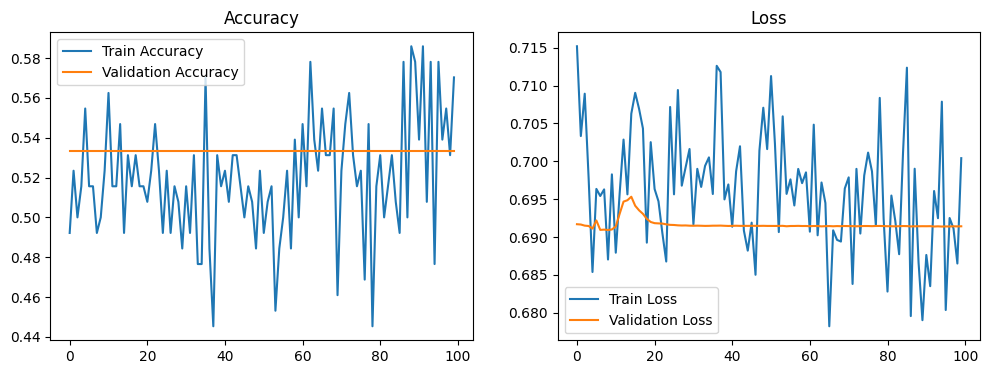

In [8]:
import PIL
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0




DATA_DIR = '/content/drive/MyDrive/spiral.ai/Spiral galaxies'
classes = os.listdir(DATA_DIR)
print("Classes: ", classes)

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 40
VAL_SPLIT = 0.2
RANDOM_SEED = 7

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=(0.8, 1.2),
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(

    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=40,
    class_mode='binary',
    subset='training',
    seed = 7
)
print (train_generator)
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed = 7
)

base = EfficientNetB0(include_top=False, weights="imagenet",
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base.trainable = False

inputs  = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
  )
]


history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight={0: 1, 1: 1}
)
for layer in base.layers[int(len(base.layers)*0.6):]:
    layer.trainable = True
#  drop learning‑rate x10



model.load_weights('best_model.h5')

y_pred = (model.predict(val_generator) > 0.5).astype(int)
print(classification_report(val_generator.classes, y_pred))
print(confusion_matrix(val_generator.classes, y_pred))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


model.save('my_model.keras')


In [ ]:
from google.colab import files
files.download('galaxy_classifier.h5')

FileNotFoundError: Cannot find file: galaxy_classifier.h5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720


In [ ]:
!ls "/content/drive/MyDrive/spiral.ai/Spiral galaxies"

0  1


In [ ]:
%cd ./MyDrive


[Errno 2] No such file or directory: './MyDrive'
/content


In [ ]:
%pwd

'/content'

In [ ]:
!unzip /content/drive/MyDrive/spiral.ai/Spiral\ galaxies -d  /content/drive/MyDrive/Spiral\ galaxies

unzip:  cannot find or open /content/drive/MyDrive/spiral.ai/your_zip_file.zip, /content/drive/MyDrive/spiral.ai/your_zip_file.zip.zip or /content/drive/MyDrive/spiral.ai/your_zip_file.zip.ZIP.


In [ ]:
%cd /content/drive

/content/drive


In [ ]:
%cd ./MyDrive

/content/drive/MyDrive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
%cd ./Spiral\ galaxies/

/content/drive/MyDrive/Spiral galaxies


In [ ]:
%pwd

'/content/drive/MyDrive/Spiral galaxies'

/content/drive/MyDrive/Spiral galaxies

Importing libraries